### Data Preparation

First of all we need to properly prepare our data. Therefor I implemented a PyTorch Dataset for the data to be conveniently accessed during training and validation. 

Moreover I performed some data augmentation, by applying a random horizontal flip and a random rotation. 
I choose to not use a horizontal flip, because for example in the case of baskets this would destroy the meaning of the image. 
Since the images are very low resolution gray scale images i decided to not apply any additional noise and color transforms.

Stats of the data:
    - 5 classes, 10.000 images in training set, 5.000 in test set
    - 28 x 28 images -> 784 features

In [2]:
from torchvision.transforms import v2
import torch

transforms = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.RandomHorizontalFlip(p = 0.5),
    v2.RandomRotation(degrees = 10),
    v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Width and height shift
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

test_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

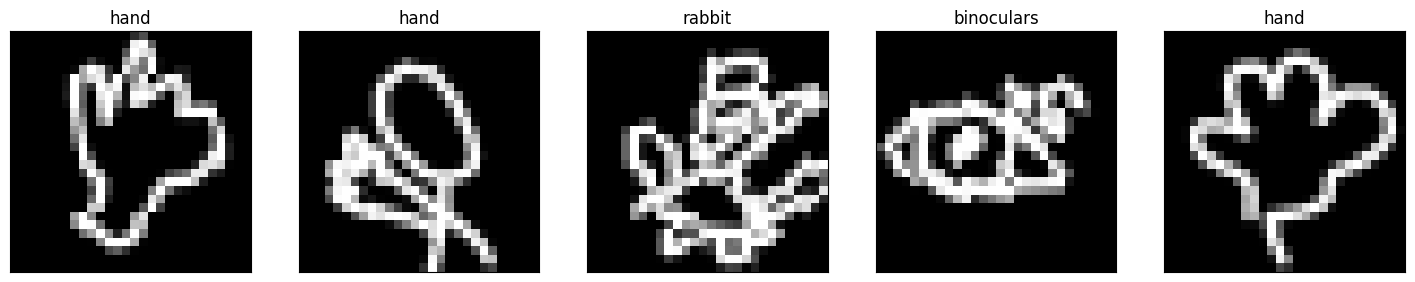

In [3]:
from torch.utils.data import Dataset
import torch
import polars as pl
import os
from PIL import Image
import matplotlib.pyplot as plt

# Classification targets & subfolder names
classes = {
    0: 'basket',
    1: 'eye',
    2: 'binoculars',
    3: 'rabbit',
    4: 'hand',
}

class QuickDrawDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pl.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path, label = self.img_labels.row(idx)[1:]
        img_path = os.path.join(self.img_dir, img_path)
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, label


# Create Train and Test Datasets
training_data = QuickDrawDataset('dataset/train.csv', 'dataset/images', transforms)
test_data = QuickDrawDataset('dataset/test.csv', 'dataset/images', test_transforms)

# Sample 5 random images to check if the datasets work
plt.figure(figsize=(18,9))
for i in range(0,5):
    ax= plt.subplot(1,5 ,i+1)
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    fig = ax.imshow(img.squeeze(0), cmap='gray')  # Remove the channel dimension
    plt.title(classes[label])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.show()


### General Preparation

- Import libraries
- Set the device
- build a "base" model

In [4]:
import torch.nn as nn
from torchsummary import summary

device = torch.device('mps' if torch.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')

class BaseModule(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential()

    def forward(self, x):
        return self.layers(x)

### CNN

Since the dataset is very similar to the MNIST dataset I first want to explore training a CNN from scratch to get a baseline for the performance.

Moreover I found this kaggle notebook that evaluated some choices regarding the CNN architecture. In the following I will try to replicate these experiments on this dataset.

Reference:
 - [Kaggle Notebook](https://www.kaggle.com/code/cdeotte/how-to-choose-cnn-architecture-mnist)

#### Test 1: Amount of Convolution + Pooling Layers

Based on the referenced notebook I want to check how many of these layer combinations produce the best output. More layers would result in very small images that will likely not contain any valuable features

In [5]:
# Build the three CNN models
nets = 3
cnn_conv_layer_models = [BaseModule() for _ in range(nets)]
for i in range(nets):

    # First Convolutional Layer (in every model)
    cnn_conv_layer_models[i].layers.append(nn.Conv2d(1, 24, kernel_size=5, padding='same'))
    cnn_conv_layer_models[i].layers.append(nn.LeakyReLU())
    cnn_conv_layer_models[i].layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    if i > 0:
        # Second Convolutional Layer (in every model except the first)
        cnn_conv_layer_models[i].layers.append(nn.Conv2d(24, 48, kernel_size=5, padding='same'))
        cnn_conv_layer_models[i].layers.append(nn.LeakyReLU())
        cnn_conv_layer_models[i].layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        # Third Convolutional Layer (only in the third model)
        if i == 2:
            cnn_conv_layer_models[i].layers.append(nn.Conv2d(48, 64, kernel_size=5, padding='same'))
            cnn_conv_layer_models[i].layers.append(nn.LeakyReLU())
            cnn_conv_layer_models[i].layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    # Output sizes after convolutional layers
    # 28x28 -> 14x14 -> 7x7 -> 3x3
    # 24*14*14 -> 48*7*7 -> 64*3*3
    conv_out = [24*14*14, 48*7*7, 64*3*3]

    cnn_conv_layer_models[i].layers.append(nn.Flatten())
    cnn_conv_layer_models[i].layers.append(nn.Linear(conv_out[i], 256))
    cnn_conv_layer_models[i].layers.append(nn.LeakyReLU())
    cnn_conv_layer_models[i].layers.append(nn.Linear(256, 5))

# Print models
for i in range(nets):
    summary(cnn_conv_layer_models[i], input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 28, 28]             624
         LeakyReLU-2           [-1, 24, 28, 28]               0
         MaxPool2d-3           [-1, 24, 14, 14]               0
           Flatten-4                 [-1, 4704]               0
            Linear-5                  [-1, 256]       1,204,480
         LeakyReLU-6                  [-1, 256]               0
            Linear-7                    [-1, 5]           1,285
Total params: 1,206,389
Trainable params: 1,206,389
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 4.60
Estimated Total Size (MB): 4.97
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Ou

In [6]:
import torch.nn.functional as F

# Train and test functions

def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        logits = model(data)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    return loss


def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            logits = model(data)
            test_loss += criterion(logits, target).item()  # sum up batch loss
            preds = F.log_softmax(logits, dim=1)
            pred = preds.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),test_acc
        ))
    return test_loss,test_acc

In [7]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import LambdaLR

# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20

# DataLoader
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=6)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=6)

# Training
train_criterion = nn.CrossEntropyLoss() # CrossEntropyLoss combines log-softmax + NLLLoss
test_criterion = nn.CrossEntropyLoss(reduction='sum') # For test function

testAcc = []

for i in range(nets):
    print(f"Training model with {i+1} conv + pool layers")
    model = cnn_conv_layer_models[i].to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = LambdaLR(optimizer, lambda epoch: 0.95 ** epoch)

    for epoch in range(1, num_epochs + 1):
        train(model, device, train_loader, train_criterion, optimizer, epoch).item()
        _, a = test(model, device, test_loader, test_criterion)
        testAcc.append(a)
        scheduler.step()

plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot(history[i].history['val_acc'],linestyle=styles[i])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.89,1])
plt.show()


Training model with 1 conv + pool layers


KeyboardInterrupt: 

In [ ]:
nets = 6
cnn_num_kernels_models = [BaseModule() for _ in range(nets)]
for i in range(nets):
    cnn_num_kernels_models[i].layers.append(nn.Conv2d(1, i*8+8, kernel_size=5, padding='same'))
    cnn_num_kernels_models[i].layers.append(nn.LeakyReLU())
    cnn_num_kernels_models[i].layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    cnn_num_kernels_models[i].layers.append(nn.Conv2d(i*8+8, i*16+16, kernel_size=5, padding='same'))
    cnn_num_kernels_models[i].layers.append(nn.LeakyReLU())
    cnn_num_kernels_models[i].layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    cnn_num_kernels_models[i].layers.append(nn.Flatten())
    cnn_num_kernels_models[i].layers.append(nn.Linear((i*16+16)*7*7, 256))
    cnn_num_kernels_models[i].layers.append(nn.LeakyReLU())
    cnn_num_kernels_models[i].layers.append(nn.Linear(256, 5))

# Print models
for i in range(nets):
    summary(cnn_num_kernels_models[i], input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]             208
         LeakyReLU-2            [-1, 8, 28, 28]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           3,216
         LeakyReLU-5           [-1, 16, 14, 14]               0
         MaxPool2d-6             [-1, 16, 7, 7]               0
           Flatten-7                  [-1, 784]               0
            Linear-8                  [-1, 256]         200,960
         LeakyReLU-9                  [-1, 256]               0
           Linear-10                    [-1, 5]           1,285
Total params: 205,669
Trainable params: 205,669
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.78
Estimated T

In [ ]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20

# DataLoader
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=6)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=6)

# Training
train_criterion = nn.CrossEntropyLoss() # CrossEntropyLoss combines log-softmax + NLLLoss
test_criterion = nn.CrossEntropyLoss(reduction='sum') # For test function

for i in range(nets):
    print(f"Training model with {i*8+8} and {i*16+16} kernels")
    model = cnn_num_kernels_models[i].to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = LambdaLR(optimizer, lambda epoch: 0.95 ** epoch)
    trainLoss = []
    testLoss = []
    testAcc = []

    for epoch in range(1, num_epochs + 1):
        trainLoss.append(train(model, device, train_loader, train_criterion, optimizer, epoch).item())
        t,a = test(model, device, test_loader, test_criterion)
        testLoss.append(t)
        testAcc.append(a)
        scheduler.step()

Training model with 8 and 16 kernels
Train Epoch: 1 [0/75000 (0%)] Loss: 0.333955
Train Epoch: 1 [6400/75000 (9%)] Loss: 0.344451
Train Epoch: 1 [12800/75000 (17%)] Loss: 0.098977
Train Epoch: 1 [19200/75000 (26%)] Loss: 0.232188
Train Epoch: 1 [25600/75000 (34%)] Loss: 0.220662
Train Epoch: 1 [32000/75000 (43%)] Loss: 0.130773
Train Epoch: 1 [38400/75000 (51%)] Loss: 0.267109
Train Epoch: 1 [44800/75000 (60%)] Loss: 0.113791
Train Epoch: 1 [51200/75000 (68%)] Loss: 0.269854
Train Epoch: 1 [57600/75000 (77%)] Loss: 0.093394
Train Epoch: 1 [64000/75000 (85%)] Loss: 0.152315
Train Epoch: 1 [70400/75000 (94%)] Loss: 0.209864

Test set: Average loss: 0.1552, Accuracy: 23685/25000 (95%)

Train Epoch: 2 [0/75000 (0%)] Loss: 0.308205
Train Epoch: 2 [6400/75000 (9%)] Loss: 0.399003
Train Epoch: 2 [12800/75000 (17%)] Loss: 0.205928
Train Epoch: 2 [19200/75000 (26%)] Loss: 0.154390
Train Epoch: 2 [25600/75000 (34%)] Loss: 0.236444
Train Epoch: 2 [32000/75000 (43%)] Loss: 0.232380
Train Epoch: 2 

KeyboardInterrupt: 

In [8]:
nets = 2
cnn_num_dense_layer_models = [BaseModule() for _ in range(nets)]

for i in range(nets):
    cnn_num_dense_layer_models[i].layers.append(nn.Conv2d(1, 32, kernel_size=5, padding='same'))
    cnn_num_dense_layer_models[i].layers.append(nn.LeakyReLU())
    cnn_num_dense_layer_models[i].layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    cnn_num_dense_layer_models[i].layers.append(nn.Conv2d(32, 64, kernel_size=5, padding='same'))
    cnn_num_dense_layer_models[i].layers.append(nn.LeakyReLU())
    cnn_num_dense_layer_models[i].layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    cnn_num_dense_layer_models[i].layers.append(nn.Flatten())
    cnn_num_dense_layer_models[i].layers.append(nn.Linear(64*7*7, 256))
    cnn_num_dense_layer_models[i].layers.append(nn.LeakyReLU())

    if i == 0:
        cnn_num_dense_layer_models[i].layers.append(nn.Linear(256, 5))
    else:
        cnn_num_dense_layer_models[i].layers.append(nn.Linear(256, 128))
        cnn_num_dense_layer_models[i].layers.append(nn.LeakyReLU())
        cnn_num_dense_layer_models[i].layers.append(nn.Linear(128, 5))

# Print models
for i in range(nets):
    summary(cnn_num_dense_layer_models[i], input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
         LeakyReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          51,264
         LeakyReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                  [-1, 256]         803,072
         LeakyReLU-9                  [-1, 256]               0
           Linear-10                    [-1, 5]           1,285
Total params: 856,453
Trainable params: 856,453
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 3.27
Estimated T

In [9]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20

# DataLoader
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=6)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=6)

# Training
train_criterion = nn.CrossEntropyLoss() # CrossEntropyLoss combines log-softmax + NLLLoss
test_criterion = nn.CrossEntropyLoss(reduction='sum') # For test function

for i in range(nets):
    print(f"Training model with {i+1} dense layers")
    model = cnn_num_dense_layer_models[i].to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = LambdaLR(optimizer, lambda epoch: 0.95 ** epoch)
    trainLoss = []
    testLoss = []
    testAcc = []

    for epoch in range(1, num_epochs + 1):
        trainLoss.append(train(model, device, train_loader, train_criterion, optimizer, epoch).item())
        t,a = test(model, device, test_loader, test_criterion)
        testLoss.append(t)
        testAcc.append(a)
        scheduler.step()

Training model with 1 dense layers
Train Epoch: 1 [0/75000 (0%)] Loss: 1.613632
Train Epoch: 1 [6400/75000 (9%)] Loss: 0.477903
Train Epoch: 1 [12800/75000 (17%)] Loss: 0.424915
Train Epoch: 1 [19200/75000 (26%)] Loss: 0.404655
Train Epoch: 1 [25600/75000 (34%)] Loss: 0.364250
Train Epoch: 1 [32000/75000 (43%)] Loss: 0.391702
Train Epoch: 1 [38400/75000 (51%)] Loss: 0.446629
Train Epoch: 1 [44800/75000 (60%)] Loss: 0.213461
Train Epoch: 1 [51200/75000 (68%)] Loss: 0.285810
Train Epoch: 1 [57600/75000 (77%)] Loss: 0.225441
Train Epoch: 1 [64000/75000 (85%)] Loss: 0.160558
Train Epoch: 1 [70400/75000 (94%)] Loss: 0.143415

Test set: Average loss: 0.2036, Accuracy: 23334/25000 (93%)

Train Epoch: 2 [0/75000 (0%)] Loss: 0.147010
Train Epoch: 2 [6400/75000 (9%)] Loss: 0.194148
Train Epoch: 2 [12800/75000 (17%)] Loss: 0.317836
Train Epoch: 2 [19200/75000 (26%)] Loss: 0.101981
Train Epoch: 2 [25600/75000 (34%)] Loss: 0.195652
Train Epoch: 2 [32000/75000 (43%)] Loss: 0.324563
Train Epoch: 2 [3

KeyboardInterrupt: 